# Thyroid data modeling and prediction

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from scipy.io import loadmat
import pandas as pd
from sklearn import neural_network

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns

import collections

Import the data

In [2]:
#import mat file
filename = "datasets/thyroidTrain.mat"

mat = loadmat(filename)

Xtrain = mat["trainThyroidInput"]
Ytrain = mat["trainThyroidOutput"]
Xtest = mat["testThyroidInput"]

print("Xtrain :", Xtrain.shape)
print("Ytrain : ", Ytrain.shape)
print("Xtest : ", Xtest.shape)

Xtrain : (5000, 21)
Ytrain :  (5000, 3)
Xtest :  (2200, 21)


perform PCA

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16, copy=True, whiten=True, svd_solver='randomized', tol=0.0, iterated_power='auto', random_state=None)
X_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

Perform normalization

In [4]:
from sklearn.preprocessing import normalize
X_pca = normalize(X_pca, axis=0)
Xtest = normalize(Xtest, axis=0)

<IPython.core.display.Javascript object>


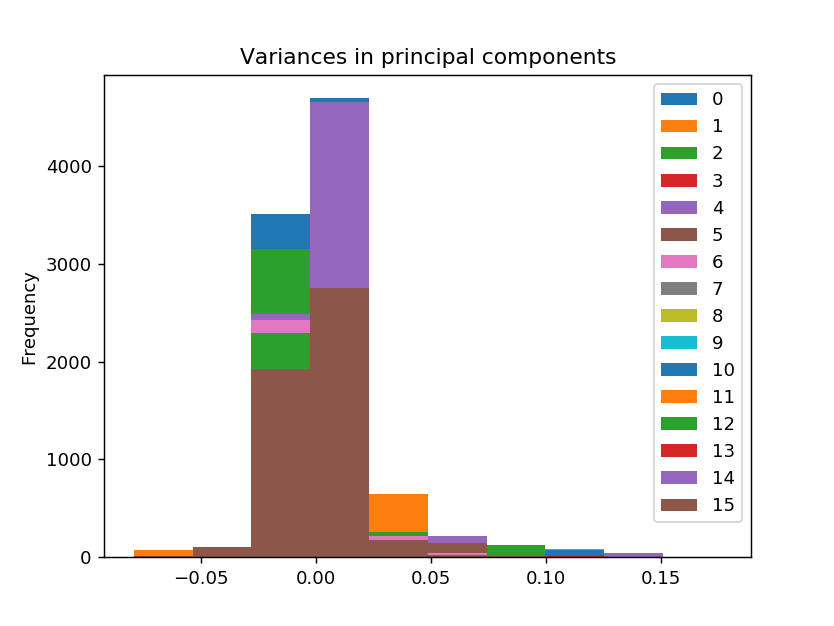

Variance ratios  [0.31036517 0.16269327 0.09523745 0.09042903 0.06840949 0.05432391
 0.04777146 0.03371469 0.0233358  0.02234603 0.02085478 0.01907191
 0.01858134 0.01493246 0.01288431 0.00311985]
Sum of variace ratios  0.9980709630518905


<IPython.core.display.Javascript object>


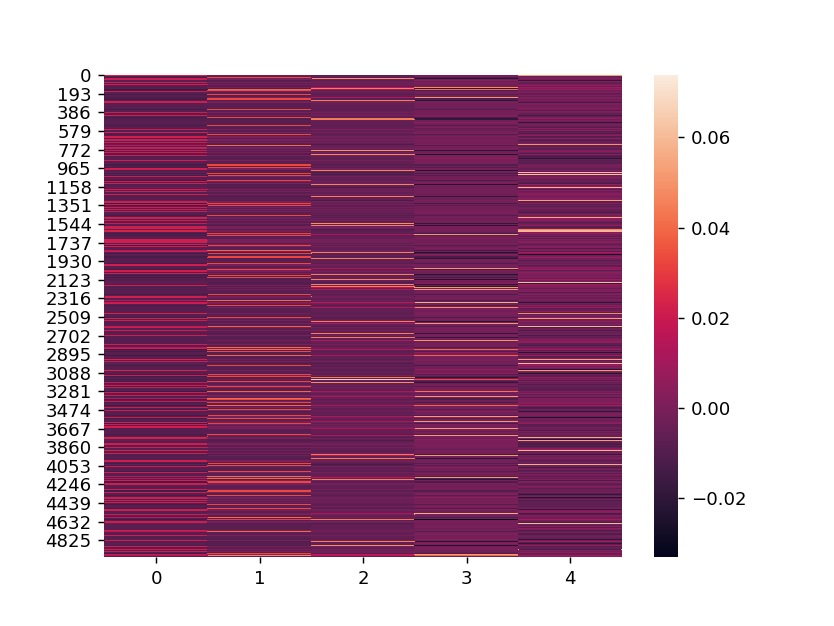

In [5]:
#plot both the training data reduced by pca to see the variance in the datset 
pd.DataFrame(X_pca).plot(kind='hist', title='Variances in principal components')
plt.show()
print("Variance ratios ", pca.explained_variance_ratio_)
print("Sum of variace ratios ", np.sum(pca.explained_variance_ratio_))
plt.figure()
ax = sns.heatmap(X_pca[:,:5])

[array([1, 2, 3])]
(5000,)


<IPython.core.display.Javascript object>


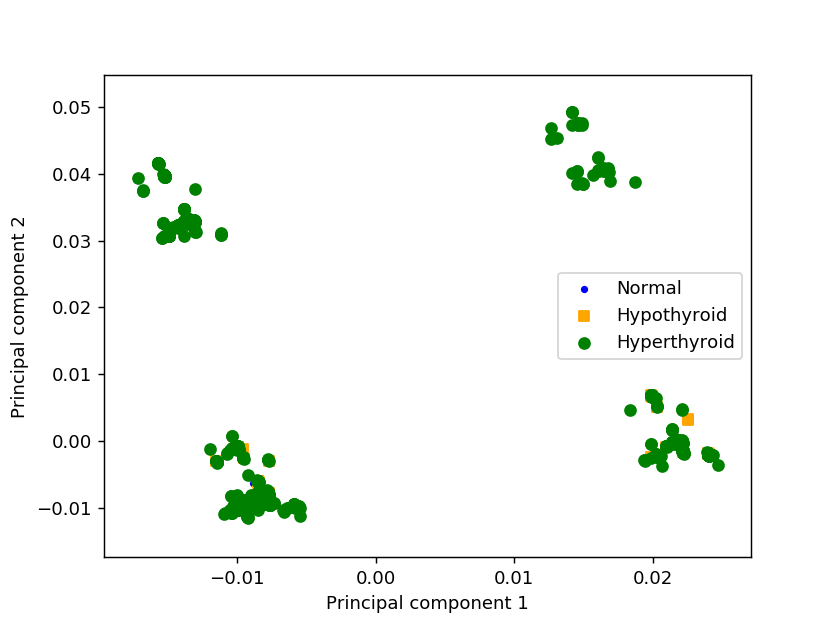

Counter({3: 4627, 2: 260, 1: 113})


In [6]:
from sklearn.preprocessing import OneHotEncoder
#plot the training data with the principal components
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([[1], [2], [3]])
print(enc.categories_)
Y = enc.inverse_transform(Ytrain).reshape(len(Xtrain))
print(Y.shape)
X0, X1, X2 = X_pca[Y == 1], X_pca[Y == 2], X_pca[Y == 3]

fig, ax = plt.subplots()
ax.scatter(X0[:, 0], X0[:, 1], color="blue", marker=".", label="Normal")
ax.scatter(X1[:, 0], X1[:, 1], color="orange", marker=",", label="Hypothyroid")
ax.scatter(X2[:, 0], X2[:, 1], color="green", marker="o", label="Hyperthyroid")
ax.set_xlabel("Principal component 1")
ax.set_ylabel("Principal component 2")
plt.legend()
fig.show()
print(collections.Counter(Y))

In [7]:
#set cross validation
kf = 10

<IPython.core.display.Javascript object>


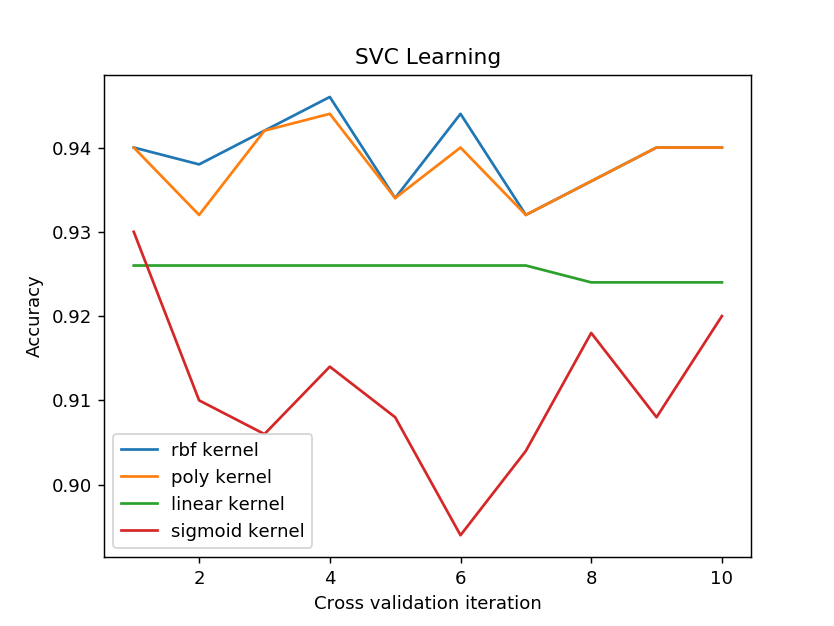

Maximum accuracy 0.9391999999999999
Best method ' rbf ' kernel


In [8]:
from sklearn.svm import SVC
#try SVM classifier
kernel_arr = ['rbf', 'poly', 'linear', 'sigmoid']
mean_accuracy = []
plt.figure()
for kernel in kernel_arr:
    svc = SVC(kernel=kernel, C=1, gamma='scale', degree=1, coef0=1)
    scores_svc = cross_val_score(svc, X_pca, Y, cv=kf)
    mean_accuracy.append(scores_svc.mean())
    plt.plot(range(1, len(scores_svc)+1),scores_svc, label='%s kernel'%kernel)
plt.ylabel("Accuracy")
plt.xlabel("Cross validation iteration")
plt.title("SVC Learning")
plt.legend()
plt.show()
max_accuracy = max(mean_accuracy)
print("Maximum accuracy", max_accuracy)
print("Best method '", kernel_arr[mean_accuracy.index(max_accuracy)],"' kernel" )

In [16]:
from sklearn.ensemble import RandomForestClassifier
rnf = RandomForestClassifier(n_estimators=20, max_depth=None, min_samples_split=10, random_state=10)
scores_rnf = cross_val_score(rnf, X_pca, Y, cv=kf)
print(scores_rnf.mean())

0.9366


We see that both the classifiers have similar accuracies in cross validation. We use random forest to predict thyroid now

<IPython.core.display.Javascript object>


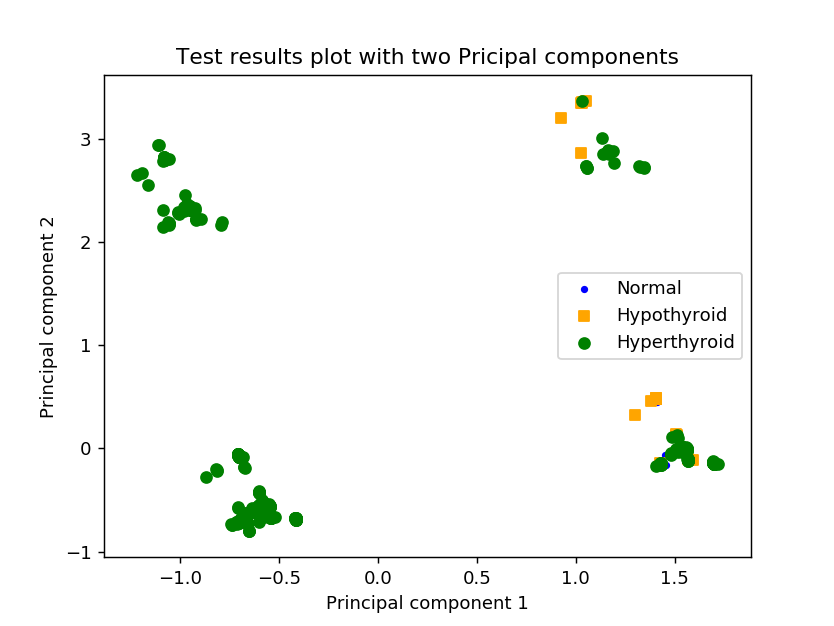

Counter({3: 1810, 1: 363, 2: 27})


In [17]:
rnf.fit(X_pca,Y)
Ytest = rnf.predict(Xtest_pca)
XT0, XT1, XT2 = Xtest_pca[Ytest == 1], Xtest_pca[Ytest == 2], Xtest_pca[Ytest == 3]
plt.figure()
plt.scatter(XT0[:, 0], XT0[:, 1], color="blue", marker=".", label="Normal")
plt.scatter(XT1[:, 0], XT1[:, 1], color="orange", marker=",", label="Hypothyroid")
plt.scatter(XT2[:, 0], XT2[:, 1], color="green", marker="o", label="Hyperthyroid")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Test results plot with two Pricipal components")
plt.legend()
fig.show()
print(collections.Counter(Ytest))

The prediction says more samples fall in hyperthyroid